# Exercise 5 - Image classification with Feature Maps (30 Points)

In this exercise you will learn how feature maps can be used improve the accuracy of image classifiers based on softmax regression.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        x.y.z
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=18310)

In [1]:
# General
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math

## Softmax Regression

In this classification task we have more than two classes, therefore we use *softmax regression* as the natural extension of logistic regression (see exercise 2).

Recall, that in softmax regression we have features $x\in\mathbb{R}^n$ which we want to classify into $m$ classes.
The goal is then to find a matrix $\theta\in\mathbb{R}^{n\times m}$, so that

\begin{equation}
p(y=i|x) = \cfrac{\exp\left(x^T\theta^{(i)}\right)}{\sum_{j=1}^{m}\exp\left(x^T\theta^{(j)}\right)}
\end{equation}

where $\theta^{(i)}$ is the i-th column of $\theta$.

## Dataset

For this exercise we use a preprocessed subset of a dataset for [Scene Classification](https://www.kaggle.com/nitishabharathi/scene-classification). All images are 128x128 grayscale images from one of three classes:
- Buildings
- Forest
- Mountains

The goal of this exercise is to train classifiers that can classify images into their respective scenery.

### Task 1 (1 Point)

The dataset is stored as numpy arrays under `X.npy` (images) and `Y.npy` (labels).

Load the dataset and display an image per class using matplotlib.

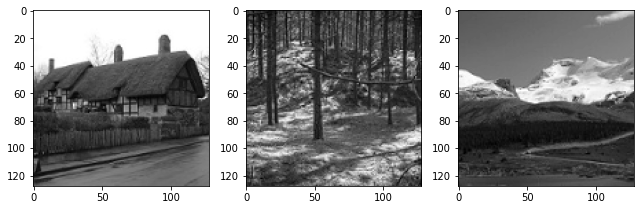

In [2]:
# TODO: Load dataset and display images
X = np.load('X.npy')
Y = np.load('Y.npy')

fs = 3
n_classes = 3
fig, axs = plt.subplots(nrows=1, ncols=n_classes, figsize=(3*fs,fs))
for i in range(n_classes):
    imgs = X[Y==i]
    img = imgs[np.random.randint(imgs.shape[0])]
    axs[i].imshow(img.reshape((128,128)), cmap='gray')
plt.tight_layout()

# No feature map

A first approach for Softmax Regression would be to take the raw pixels as features. In our case, every feature is a vector of size 28x28=16384, containing the pixel intensities.

### Task 2 (3 Points)

In scikit-learn, softmax regression is implemented within the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class. 

Use scikit learn to fit softmax regression on the images and evaluate the accuracy on train- and test data.
What do you observe?

Hint: 
- Use the keyword "multinomial"

In [3]:
# TODO: Split data into train and test data (1 Point)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# TODO: fit softmax regression (1 Point)
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression(multi_class="multinomial", random_state=0)
regressor.fit(X_train,Y_train)

# TODO: get accuracy on train- and test data (1 Point)
train_acc = np.sum(regressor.predict(X_train) == Y_train)/Y_train.shape[0]
test_acc = np.sum(regressor.predict(X_test) == Y_test)/Y_test.shape[0]
print(f'Train Accuracy: {train_acc}\t Test Accuracy: {test_acc}')

Train Accuracy: 0.9777777777777777	 Test Accuracy: 0.43333333333333335


C:\Users\Paul Kahlmeyer\anaconda3\envs\statlearn\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Observation: Overfitting

## Normalization

You probably observed, that softmax regression on the raw pixel values does not lead to good results.

One reason for this is that pixel values are *unnormalized*. This means, different dimensions of the features are in different ranges and have different statistical properties.

When we use a regressor, we heavily rely on the dot product between two vectors as distance measure.

Recall, that for two vectors $x^{(1)}, x^{(2)}\in\mathbb{R}^d$ the dot product is defined as

\begin{align}
(x^{(1)})^Tx^{(2)} = \sum_{i=1}^d x^{(1)}_ix^{(2)}_i
\end{align}

In this distance measure, products over different feature dimensions are added together. If we dont want certain dimensions to dominate others, we have to normalize the features.

### Task 3 (2 Points)

Visualize the mean values and the variance for each feature dimension. What do you observe?

Hint:
- Reshape the values into image dimensions

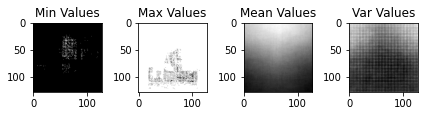

In [4]:
# TODO: Visualize mean and variance of pixel features
# calculate means and variances (1 Point)
# display means and variances (1 Point)
min_img = np.min(X_train, axis=0)
max_img = np.max(X_train, axis=0)
mean_img = np.mean(X_train, axis=0)
std_img = np.var(X_train, axis=0)

fig, axs = plt.subplots(nrows=1, ncols=4)
axs[0].imshow(min_img.reshape((128,128)), cmap='gray')
axs[0].set_title('Min Values')
axs[1].imshow(max_img.reshape((128,128)), cmap='gray')
axs[1].set_title('Max Values')
axs[2].imshow(mean_img.reshape((128,128)), cmap='gray')
axs[2].set_title('Mean Values')
axs[3].imshow(std_img.reshape((128,128)), cmap='gray')
axs[3].set_title('Var Values')
plt.tight_layout()

A common normalization technique is to estimate the mean $\mu$ and variance $\sigma^2$ of each feature dimension and to transform each feature $x^{(i)}$ with 

\begin{align}
\cfrac{x^{(i)}-\mu}{\sigma}
\end{align}

The resulting features should have approximately a mean of 0 and a variance of 1 in each dimension.

### Task 4 (4 Points)

Estimate $\mu$ and $\sigma^2$ for each feature dimension from the training data.
Implement a function, that takes a dataset and applies the normalization technique from above.
Similar to task 4, visualize the mean and variance values for the features of the normalized data.

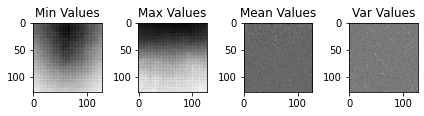

In [5]:
def transform_norm(X, mean, std):
    # TODO: implement normalization (1 Point)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    return (X-mean)/std

# TODO: estimate mu and sigma^2 (1 Point)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# TODO: normalize train images, test images (1 Point)
X_train_scaled = transform_norm(X_train, mean, std)
X_test_scaled = transform_norm(X_test, mean, std)


# TODO: visualize mean and variance of normalized pixel features (1 Point)
min_img = np.min(X_train_scaled, axis=0)
max_img = np.max(X_train_scaled, axis=0)
mean_img = np.mean(X_train_scaled, axis=0)
std_img = np.var(X_train_scaled, axis=0)

fig, axs = plt.subplots(nrows=1, ncols=4)
axs[0].imshow(min_img.reshape((128,128)), cmap='gray')
axs[0].set_title('Min Values')
axs[1].imshow(max_img.reshape((128,128)), cmap='gray')
axs[1].set_title('Max Values')
axs[2].imshow(mean_img.reshape((128,128)), cmap='gray')
axs[2].set_title('Mean Values')
axs[3].imshow(std_img.reshape((128,128)), cmap='gray')
axs[3].set_title('Var Values')
plt.tight_layout()

### Task 5 (1 Point)
Now use logistic regression on the transformed features. Calculate the accuracies on the train- and testset.

In [6]:
# TODO: use logistic regression on normalized features
regressor.fit(X_train_scaled,Y_train)
train_acc = np.mean(regressor.predict(X_train_scaled) == Y_train)
test_acc = np.mean(regressor.predict(X_test_scaled) == Y_test)
print(f'Train Accuracy: {train_acc}\t Test Accuracy: {test_acc}')

Train Accuracy: 1.0	 Test Accuracy: 0.5226666666666666


C:\Users\Paul Kahlmeyer\anaconda3\envs\statlearn\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Handcrafted features

Altough we normalized the features, our accuracy is still quite low.

This is because we take pixel values as features, which is extremely inconsistent. 

**Feature maps** attempt to bypass this inconsistency by transforming the pixel vector into a different, more consistent feature vector. 

Especially in the field of image classification, a lot of attempts were made to derive features from images trough a pipeline of preprocessing.

We want to use edges in our images as features.
Edges are visual boundaries of objects. Hence they contain information about objects in images.
In grayscale images, we can interpret edges as sudden changes of pixel intensities in some direction.

## Convolution
In order to detect these changes, we will use linear filters on the images. A linear filter is determined by a kernel matrix $K$, that describes how a new pixel is created by a linear combination of its neighbouring pixels.

As an example, consider the following [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) matrix:

\begin{align}
K=\begin{bmatrix}
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}\\
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}\\
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}
\end{bmatrix}
\end{align}

For the calculation of a new pixel, we take the $3\times3$ neighbourhood around the original pixel, multiply each of the neighbours with its corresponding entry in $K$ and sum everything up. The example kernel will simply set a pixel to the average of its neighbouring pixels and is called *average filter*. We consider only kernels with *odd dimensions*.

### Task 6 (6 Points)
Implement a function, that performs convolution on an image with a given kernel. Consider neighbourhood values that are not within the image as zero (zero padding). Filter an image from the dataset with the average filter from the example and display the result using matplotlib.

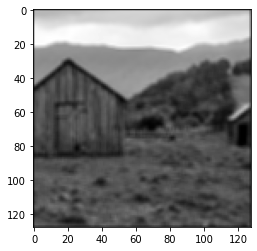

In [7]:
def convolute(img, kernel):
    # TODO: Implement convolution function (4 Points)
    h, w = img.shape
    kh, kw = kernel.shape
    padh, padw = int(kh/2), int(kw/2)
    tmp_img = np.zeros((2*padh+h, 2*padw+w))
    tmp_img[padh:-padh, padw:-padw] = img
    res_img = np.zeros(img.shape)
    for i in range(h):
        for j in range(w):
            neighbourhood = tmp_img[i: i+kh, j: j+kw]
            res_img[i,j] = np.sum(np.multiply(neighbourhood, kernel))
    return res_img

# TODO: perform average filtering on image (2 Points)
img = X[2].reshape((128,128))
kernel = np.ones((3,3))/9
res = convolute(img, kernel)
plt.imshow(res, cmap='gray')

As mentioned before, edges correspond to a sudden change of the pixel intensities. 
We can detect these changes in horizontal and vertical direction with the kernel matrices

\begin{align}
K_x = \begin{bmatrix}
-1&0&1\\
-2&0&2\\
-1&0&1
\end{bmatrix}, K_y = \begin{bmatrix}
-1&-2&-1\\
0&0&0\\
1&2&1
\end{bmatrix}
\end{align}

These kernel matrices are called *Sobel Filters* and serve as an approximation to the gradient of the pixel values.
Let $I_x$ and $I_y$ be the images obtained by filtering our original image with $K_x$ and $K_y$ respectively.

The magnitude of our gradient in both directions can be calculated by 

\begin{align}
|G| = \sqrt{I_x^2+I_y^2}
\end{align}


### Task 7 (3 Points)

Implement a function that calculates the gradient image for a given image. Test this function and visualize an example for a gradient image.

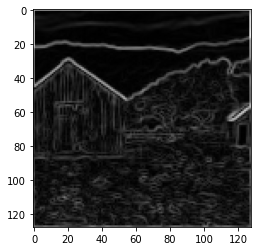

In [8]:
def grad_img(img):
    # TODO: Calculate gradient image (2 Points)
    # correct kernels: 1 Point
    # correct calculation: 1 Point
    kernel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    kernel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

    I_x = convolute(img, kernel_x)
    I_y = convolute(img, kernel_y)
    
    G = np.sqrt(I_x**2+I_y**2)
    
    return G
    
# TODO: calculate + display gradient image (1 Point)
img = X[2].reshape((128,128))
grad = grad_img(img)
plt.imshow(grad, cmap='gray')

### Task 8 (2 Points)

Now we want to use this function to create a transformed dataset. Implement a function that takes a dataset of images and transforms it into a dataset of gradient images. Apply this function to the train- and testset.

Note: This might take a while. Have a look at the python package [tqdm](https://tqdm.github.io/) to visualize the conversion process.

In [9]:
from tqdm import tqdm
def transform_grad(X):
    # TODO: transform dataset into gradient image vectors (1 Point)
    ret = []
    for img in tqdm(X):
        grad = grad_img(img.reshape((128,128)))
        ret.append(grad.flatten())
    return np.stack(ret)

# TODO: transform train- and testset (1 Point)
X_train_grad = transform_grad(X_train)
X_test_grad = transform_grad(X_test)

100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [02:45<00:00,  4.52it/s]


### Task 9 (1 Point)
Now use logistic regression on the transformed trainset. What are the accuracies on the train- and testset?

In [10]:
# TODO: apply logistic regression on transformed train- and testset
regressor.fit(X_train_grad,Y_train)
train_acc = np.mean(regressor.predict(X_train_grad) == Y_train)
test_acc = np.mean(regressor.predict(X_test_grad) == Y_test)
print(f'Train Accuracy: {train_acc}\t Test Accuracy: {test_acc}')

Train Accuracy: 1.0	 Test Accuracy: 0.6853333333333333


C:\Users\Paul Kahlmeyer\anaconda3\envs\statlearn\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Deep Learning Features

In practice, Deep Learning features are the state of the art for most image classification tasks.

Deep Learning features are obtained by processing an input feature with a trained *deep neural network*.
Such a neural network consists of multiple processing steps (*layers*) that are applied sequentially to the input feature.
The resulting features can be used for multiple tasks, such as classification using softmax regression.

We will not cover the topic of deep learning here, we rather view neural nets as a blackbox that works as a feature map.

## Pytorch

We will use a pretrained deep neural network from the deep learning library [Pytorch](https://pytorch.org/).

Install Pytorch and run the imports below.

In [11]:
# TODO: make sure you can import this
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

## ResNet18

[ResNet18](https://arxiv.org/pdf/1512.03385.pdf) is a special case of a Deep Learning architecture, that was developed by Microsoft in 2015. It is called ResNet18, because it has 18 layers. 

We want to use ResNet18 as a feature map, that transforms our pixel feature vectors in some other representation. 

<div>
<img src="images/dl_features.png" width="300"/>
</div>

Pytorch offers the opportunity to use several [pretrained models](https://pytorch.org/vision/0.8/models.html). 
The pretrained ResNet18 was trained to classify images from [ImageNet](http://www.image-net.org/). 
ImageNet is a image classification challenge, where RGB images have to be classified into one of 1000 classes.
Therefore the output of ResNet18 is a vector of size 1000, with the entries showing the confidence in the respective class.

The last layer in ResNet18 corresponds to $\theta$ from the softmax regression. However the pretrained ResNet18 was trained on a different image classification task. Therefore this $\theta$ is of no good for us. We are only interested in the features vectors that are fed into the softmax regression.

An easy way to ignore the final softmax layer and to output the input to this layer is to replace it with a dummy layer, that does nothing but return its input. Below you find an example:

In [12]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
model = models.resnet18(pretrained=True)
model.fc = Identity()

As mentioned before, ResNet18 was trained on a different dataset and therefore has special requirements to its inputs.

ResNet18 expects its input to be
- a torch tensor
- of shape $b\times 3\times 224\times 224$, with $b$ as the batch size (number of images that are processed at once)
- normalized in a special way

Pytorch provides all the functionality to preprocess our grayscale input images into the desired form. 

The transformation `preprocess` acts as a function that does all the necessary preprocessing.

In [13]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x,x,x], axis=0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0))
])

### Task 10 (2 Points)

Use the preprocess transformation on an image from the dataset. 
Feed this preprocessed image trough the ResNet18 model.
Print the shapes of the preprocessed features and the ResNet18 features.

Hints:
- look [here](https://pytorch.org/docs/stable/torchvision/transforms.html) for an explaination on transforms
- look [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) for an example of a neural network usage in Pytorch

In [14]:
# TODO: use preprocess on image + print shape (1 Point)
img = X[0].reshape((128,128))
inp = preprocess(img)

# TODO: feed preprocessed trough model + print shape (1 Point)
res = model(inp)

inp.shape, res.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 512]))

### Task 11 (4 Points)

Now transform the train and testset into ResNet18 features. Implement a function, that converts a given dataset into ResNet18 features. Use this function on the train- and testset.

**Important**: Run your transformation within the python [context](https://book.pythontips.com/en/latest/context_managers.html) `with torch.no_grad():` to reduce memory, since we dont need the gradients.

Hints:
- You can feed multiple images trough the model at once, if you [pack them together](https://pytorch.org/docs/stable/generated/torch.cat.html) in a batch

In [15]:
def transform_dl(X, batchsize=50):
    # TODO: convert images from X into ResNet18 features (3 Points)
    inp = []
    for x in X:
        img = x.reshape((128,128)).astype(np.float32)/255
        inp.append(preprocess(img))
    inp = torch.cat(inp, dim=0)

    nmb_batches = math.ceil(X.shape[0]/batchsize)
    ret = []
    for i in tqdm(range(nmb_batches)):
        batch = inp[i*batchsize:(i+1)*batchsize]
        res = model(batch).numpy()
        ret.append(res)
    
    return np.concatenate(ret, axis=0)

# TODO: transform train- and testset (1 Point)
with torch.no_grad():
    X_train_dl = transform_dl(X_train)
    X_test_dl = transform_dl(X_test)        
        

C:\Users\Paul Kahlmeyer\anaconda3\envs\statlearn\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.36s/it]


### Task 12 (1 Point)

Use these features to perform logistic regression. What is the accuracy on the train- and testset now?

In [16]:
# TODO: apply logistic regression on transformed train- and testset
regressor.fit(X_train_dl,Y_train)
train_acc = np.mean(regressor.predict(X_train_dl) == Y_train)
test_acc = np.mean(regressor.predict(X_test_dl) == Y_test)
print(f'Train Accuracy: {train_acc}\t Test Accuracy: {test_acc}')

Train Accuracy: 1.0	 Test Accuracy: 0.988


C:\Users\Paul Kahlmeyer\anaconda3\envs\statlearn\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
